# Creating calibrated size distributions using FAAM data (PCASP and CDP)
**Erin Raif, 30 May 2023** - code version 2.

This code is inspired by previous work by **Alberto Sanchez-Marroquin** and **Sarah Barr**. 

**Major changes since version 1** - function definitions are now contained in aerosol_size_distributions.py for improved readibility. For minor changes, please see git repo documentation history.

**TL;DR**: This notebook will create particle size distributions for PCASP and CDP data from the FAAM campaign.

**TL;DR, but longer**: The PCASP probe nominally measures aerosols in the size range 0.1-3 micron. The CDP probe nominally measures cloud droplets in the size range 2-50 micron, but can be applied to aerosol by deriving particle concentrations from raw counts using a refractive index that is appropriate for aerosol. These can be used to create aerosol size distributions in the accumulation and coarse mode size ranges.

# Contents
*(note the contents formatting sometimes is a bit funky outside VSCode)*
1) [Introduction](#intro):
     - [Notebook purpose and contents](#what-does-this-notebook-actually-do)
     - [Pre-requisites](#pre-requisites-using-the-rosenberg-code)
     - [Plotting keyword arguments](#keyword-arguments-for-more-custom-plotting)
2) [Generating scattering data using MieConScat](#generating-scattering-data-using-mieconscat)
3) [Generating channel diameter (and area/volume) data using CStoDConverter](#creating-channel-diameter-and-areavolume-data-using-cstodconverter)
4) [Reading and processing aircraft data](#processing-aircraft-data)
5) [Calculating logarithmic particle size distribution data and errors](#calculating-particle-size-distribution-data-and-errors)
     - [Merging particular channels of PCASP data](#merging-bins-for-the-pcasp-data)
6) [Plotting logarithmic particle size distributions](#plotting-logarithmic-particle-size-distributions)
     - [Example - Variation of  size distributions with refractive index](#example---variation-of-distributions-with-refractive-index---flight-c274-filter-run-3)
     - [Example - Total PCASP concentration and data flag](#example---plot-total-pcasp-number-concentration-over-time---flight-c274-run-3)
     - [Example - Comparing CDP data with different humidity caps](#example---comparing-cdp-data-with-different-humidity-caps)
     - [Example - Combining PCASP and CDP data to get a total number/size/volume concentration](#example---combining-pcasp-and-cdp-data-to-get-a-total-numbersizevolume-concentration)
7) [Optional: INP data reading and plotting](#optional-reading-input-filter-data-and-metadata)


# Introductory information
<a id='intro'></a>
## How do the probes work and how does calibration work?
The probes each have thirty channels across three gain stages. Particles are counted when they pass through a laser beam, and the fall in transmitted radiation is associated with a particular size bin. These size bins have nominal particle diamater ranges attached to them. However, the effects of Mie Scattering mean that the effective diameter measured by each channel will vary according to the refractive index of the particle.

Calibration is performed by passing reference beads through the probes and acquiring counting statistics for each bin. Using the software **MieConScat**, particle scattering cross-sections for one or more refractive indices relevant to the aerosol sample can be obtained. These can be passed through the **CStoDConverter** program to get channel diameters for the particle-size distributions.

For details of the calibration process, see Rosenberg, et al. (2012). *Particle sizing calibration with refractive index correction for light scattering optical particle counters and impacts upon PCASP and CDP data collected during the Fennec campaign*. Atmos. Meas. Tech. **5**:5 doi:10.5194/amt-5-1147-2012 (from hereon in, PR12)

The above reference also contains details of the **MieConScat** program and the **CStoDConverter** program.

For mathematical details of Mie Scattering, see K. N. Liou (2002). *Introduction to Atmospheric Radiation* 2nd ed. Elsevier Science: London. **Chapters 5.2 and 5.3.**


## What does this notebook actually do?
This notebook takes calibrated size channels as calculated by Phil Rosenberg's code and creates aerosol-size distributions. $x$-errors are derived using the Rosenberg process. $y$-errors are derived from counting statistics.
$\mathrm{d}N/\mathrm{d}\log{(D)}$, $\mathrm{d}S/\mathrm{d}\log{(D)}$ and $\mathrm{d}V/\mathrm{d}\log{(D)}$ are all calculated and orthogonal distance regression is used to fit a double-moment lognormal distribution to these. The fitting process is deliberately designed to be semi-automatic to avoid the user pressing on with inappropriate starting guesses for the solver (explained later on). The user can generate total surface area values between given bounds that match channel width.

Some choices in data processing are made according to Sanchez-Marroquin, 2019 (SM19 from hereon in), which you should definitely read!

Sanchez-Marroquin et al. (2019). *Characterisation of the filter inlet system on the FAAM BAe-146 research aircraft and its use for size-resolved aerosol composition measurements*. Atmos. Meas. Tech. **12**:11. doi:10.5194/amt-12-5741-2019

## Generation of calibration files using this notebook
This notebook generates scattering information by interacting with Phil Rosenberg's programmes **MieConScat** and **CStoDConverter** in the command line. *I have only tested this on Windows, I can't promise this works on Unix systems including Jasmin so you may wish to generate these offline.*

### Pre-requisites to use the Rosenberg code
- You should have downloaded [**MieConScat**](https://sourceforge.net/projects/mieconscat/) and [**CStoDConverter**](https://sourceforge.net/projects/cstodconverter/) already. *(click links to download from Sourceforge)*
- You will need the calibration files from **FAAM**, an example version of this for *ACAO* is included in the GitHub repo. You can find these on the [CEDA archive](https://data.ceda.ac.uk/badc/faam/data/2022). I believe they are now correct and present for all campaigns. Note that they are now in NetCDF form.

## Pre-requisites for the notebook
- Imports required included in the cell below. Note that the version of xarray you have installed currently must be exactly version 2022.6.0 - a future version of this code may negate this requirement.
  - If you have a different xarray version, you should create a new conda virtual environment with the correct version of xarray. Use the command `conda install -c conda-forge xarray=2022.6.0` in the Anaconda Prompt terminal when your new environment is activated.
- There is no specific file structure needed for flight data. Cells are included for DIY generation of lists of inputs that can be passed to functions in your own loops.
- To analyse a particular flight, you should use the full (not 1 Hz) versions of both the core FAAM data and the core cloud FAAM data. Time slices should come from filters metadata
- Running this notebook in **VSCode** is recommended but not essential. VSCode allows you to see tooltips for all the functions defined in this notebook, making further coding using these functions much easier. VSCode also has debugging and live error checking in a much more accessible way than in-browser notebooks.

### Optional pre-requisites
- If you have background-subtracted $n_{\mathrm{INP}}$ data, this can be plotted alongside the data for a useful quick-look and can be used to derive $n_{s}$ values.
- This notebook assumes that $n_{\mathrm{INP}}$ data is in the format of a CSV file where each filter has a custom ID (*`filterID`*). Columns in the CSV have the concentration of INP at integer degree temperature intervals - these are named *`filterID`*`_NT`. The associated errors are found in columns in the CSV with name *`filterID`*`_err`.
- A separate metadata CSV file for information about the INP runs

## Keyword arguments for more flexible plotting
This notebook makes use of python's [`**kwargs`](https://www.geeksforgeeks.org/args-kwargs-python/) (keyword arguments) feature to pass more information to the plotting functions that have been made. This lets the user optionally pass an unlimited number of arguments to a function to increase the functionality of a function. These must be passed after the usual arguments. A list of those used in this notebook is below. Obviously if you want to customise your plot significantly more than what's below, you'll need to make your own functions/adapt mine.
Pass kwargs to functions using a dictionary (as described in the link at the start of this paragraph).

| `kwarg`                  | Format                               | Adjustment                                    |
|--------------------------|--------------------------------------|-----------------------------------------------|
| `xlim`                   | `[lower_limit,upper_limit]` (floats) | Change the x-axis limits                      |
| `ylim`                   | `[lower_limit,upper_limit]` (floats) | Change the y-axis limits                      |
| `xlabel`                 | string                               | Change the x-axis label                       |
| `ylabel`                 | string                               | Change the y-axis label                       |
| matplotlib plot kwargs   | various (NOTE - check plot function docstring to check compatibility - works with most but not all functions) | Make changes to the specific plot function, e.g. ax.errorbar() or ax.scatter(). Kwargs are the kwargs compatible with matplotlib, you should check their documentation for full functionality. Note that this will only affect plot-level parameters such as plot linewidth, and trying to change axes-level parameters such as grid visibility will not work (and probably break it!) |

An example of using the axis limit and label kwargs is in [Section 7](#plotting-inp-concentrations). An example of the use of matplotlib kwargs is in [Section 6](#plotting-logarithmic-particle-size-distributions).


In [1]:
# Standard Library
import os
import re  # regex (not sure why)
from glob import glob
import datetime as dt
#import cmath

# Others
import pandas as pd
import numpy as np
import xarray as xr # Version 2022.6.0 is the only version where this works - maybe there's a 

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib as mpl
import aerosol_size_distributions as asd

In [2]:
"""
If you are using VS Code, run this cell for interactive plots. Only do this if you
are NOT generating large numbers of plots/are closing plots as you go as it uses more memory.
Or make judicious use of plt.close('all')
"""
%matplotlib widget

In [3]:
"""
Or if you are using the standard Jupyter notebook interface, uncomment and run this cell for interactive plots.
Only do this if you are NOT generating large numbers of plots/are closing plots as you go as it uses more memory.
"""
#%matplotlib notebook

'\nOr if you are using the standard Jupyter notebook interface, uncomment and run this cell for interactive plots.\nOnly do this if you are NOT generating large numbers of plots/are closing plots as you go as it uses more memory.\n'

# Generating scattering data using MieConScat
Using the MieConScat software, you can generated tables of scattering data for particular refractive index values.
While you can generate tables for multiple refractive indices, it is probably easiest to generate individual tables for refractive indices and access them using filenames as the files can get large quickly. This is the choice that I have made here.

**Important - I have chosen a filename convention and file location of the form `.\scattering_files\scattering_INSTRUMENT_REAL+-IMAGINARYj.csv`** (e.g. `scattering_PCASP_1.58-0.01j.csv`). If you choose another convention, you will need to re-write the code here.

You will need to use particular values for the laser wavelengths and diameters you wish to investigate (in microns), and scattering angles of the probe. Defaults for each instrument are contained in dictionaries below, but of course you can edit if you feel the need.
|Instrument|Diameter range|Diameter resolution|Primary scattering angle|Secondary scattering angle|Wavelength|
|----------|--------------|-------------------|------------------------|--------------------------|----------|
|PCASP     |0.05-8        |0.001              |35-120 degrees          |60-145 degrees            |0.6328    |
|CDP       |1-100         |0.1                |1.7-14 degrees          |None                      |0.658     |

Note that in various documentation, the CDP angles are given as 4-12 degrees. This is information is abuot ten years old and currently it looks at a different range.

In [4]:
# MieConScat Program location - adjust these for your own computer
mcs_loc = r'..\MieConScat\MieConTabGenConsole.exe'
# CS_to_DConverter Program location - adjust these for your own computer
cstod_loc = r'..\CStoDConverter_1.2.10\cstodconverterconsole.exe'

In [5]:
# Where Mie Scattering information will be output
# you must make this folder for it to work
mie_scattering_folder = '.\\scattering_files'

In [6]:
# List of refractive indices to test - you may wish to generate this programmatically
# These refractive indices are those tested in SM19 and a good starting point for INP filter data.
refractive_indices = [
    1.56+0j, 1.5+0j, 1.6+0j, 1.7+0j,
    1.56+0.001j,1.56+0.003j,1.56+0.006j,1.56+0.01j
    ]

In [7]:
# Note that with the default settings this takes about 40s to create 16 calibrations
for ri in refractive_indices:
    pcasp_mie = asd.generate_scattering_table(ri, mie_scattering_folder, mcs_loc, asd.pcasp_scattering_inputs)
    cdp_mie = asd.generate_scattering_table(ri, mie_scattering_folder, mcs_loc, asd.cdp_scattering_inputs)

..\MieConScat\MieConTabGenConsole.exe -wav 0.6328 -dmin 0.05 -dmax 8 -dint 0.001 -rerimin 1.56 -imrimin 0.0 -ang1min 35 -ang1max 120 -ang2min 60 -ang2max 145 .\scattering_files\scattering_PCASP_1.56+0j.csv
..\MieConScat\MieConTabGenConsole.exe -wav 0.658 -dmin 1 -dmax 100 -dint 0.1 -rerimin 1.56 -imrimin 0.0 -ang1min 1.7 -ang1max 14 .\scattering_files\scattering_CDP_1.56+0j.csv
..\MieConScat\MieConTabGenConsole.exe -wav 0.6328 -dmin 0.05 -dmax 8 -dint 0.001 -rerimin 1.5 -imrimin 0.0 -ang1min 35 -ang1max 120 -ang2min 60 -ang2max 145 .\scattering_files\scattering_PCASP_1.5+0j.csv
..\MieConScat\MieConTabGenConsole.exe -wav 0.658 -dmin 1 -dmax 100 -dint 0.1 -rerimin 1.5 -imrimin 0.0 -ang1min 1.7 -ang1max 14 .\scattering_files\scattering_CDP_1.5+0j.csv
..\MieConScat\MieConTabGenConsole.exe -wav 0.6328 -dmin 0.05 -dmax 8 -dint 0.001 -rerimin 1.6 -imrimin 0.0 -ang1min 35 -ang1max 120 -ang2min 60 -ang2max 145 .\scattering_files\scattering_PCASP_1.6+0j.csv
..\MieConScat\MieConTabGenConsole.exe 

## Generating higher-order cross-section data
Once you have generated scattering tables using MieConScat, you must then use the calibration file provided by FAAM to generate channel diameters. However, Rosenberg advises:
- *Because of the nonlinear non-monotonic relationship between scattering cross section and diameter, the calculation of higher order properties, such as particle area or volume or log of diameter, from the estimated diameters should be approached with caution* ... *The following method is therefore recommended for calculating higher order properties. Simply replace the diameter column in the scattering data file with the quantity of interest.*

This allows you to generate scattering data for the higher-order properties of surface area and volume. Using these later on means the channels become surface area and volume bins but allows errors to be propagated.

In [8]:
# Select only csvs with diameter data (rather than existing ones with area/volume)
diameter_csvs = glob(os.path.join(mie_scattering_folder,'*j.csv'))
for csv in diameter_csvs:
    asd.create_higher_order_scatter_data(mie_scattering_folder,os.path.basename(csv))

# Creating channel diameter (and area/volume) data using CStoDConverter
You can now combine the calibration data from FAAM with the scattering data to produce channel diameter, area and volume information in linear and logarithmic form. These are stored in an `xarray` object. When applying functions from this notebook to the calibrations from FAAM, there are two things to take note of:
- PCASP calibrations are performed at the start of the campaign (time_index=0) and one for the end of the campaign (time_index=1).
- The fact that the CDP calibrations are done after most flights. These are then combined into a master calibration, which is what you should typically use for the full campaign (time_index = 0).


In the case of the ACAO campaign, which this notebook was developed for, there was only one useful PCASP calibration since the PCASP was replaced during the campaign. However, typically you should talk to the appropriate instrument scientist (currently Graeme Nott) as to which to use (or simply take an average if the two calibrations yield similar cross-sections).


In [9]:
cdp_channel_data_folder = '.\\channel_data_CDP' # you must make these folders for it to work
pcasp_channel_data_folder = '.\\channel_data_PCASP'
faam_pcasp_calibration_file = 'new_pcasp_cal.nc'
faam_cdp_calibration_file = 'new_cdp_cal.nc'
attribute_file = 'attributes_for_calibration_arrays.txt' # Set to None if not present
# These are filenames for files you will create
csv_pcasp_calibration_file = 'new_pcasp_calibration_file.csv'
csv_cdp_calibration_file = 'new_cdp_calibration_file.csv'

In [10]:
asd.create_calibration_CSV(faam_pcasp_calibration_file, 'PCASP', 
                            csv_pcasp_calibration_file, time_index=1)
# If you DO NOT want to use the master calibration, look at aerosol_size_distributions.py to
# see the changes you need to make.
asd.create_calibration_CSV(faam_cdp_calibration_file, 'CDP',
                            csv_cdp_calibration_file)

new_pcasp_calibration_file.csv created
new_cdp_calibration_file.csv created


In [11]:
# This takes a minute or so
mie_csvs = glob(os.path.join(mie_scattering_folder,'*PCASP*.csv'))
asd.run_CStoD(csv_pcasp_calibration_file, mie_csvs, cstod_loc, pcasp_channel_data_folder)
mie_csvs = glob(os.path.join(mie_scattering_folder,'*CDP*.csv'))
asd.run_CStoD(csv_cdp_calibration_file, mie_csvs, cstod_loc, cdp_channel_data_folder)

..\CStoDConverter_1.2.10\cstodconverterconsole.exe new_pcasp_calibration_file.csv .\scattering_files\scattering_PCASP_1.5+0j.csv .\channel_data_PCASP\channel_data_PCASP_1.5+0j.csv
..\CStoDConverter_1.2.10\cstodconverterconsole.exe new_pcasp_calibration_file.csv .\scattering_files\scattering_PCASP_1.5+0j_area.csv .\channel_data_PCASP\channel_data_PCASP_1.5+0j_area.csv
..\CStoDConverter_1.2.10\cstodconverterconsole.exe new_pcasp_calibration_file.csv .\scattering_files\scattering_PCASP_1.5+0j_volume.csv .\channel_data_PCASP\channel_data_PCASP_1.5+0j_volume.csv
..\CStoDConverter_1.2.10\cstodconverterconsole.exe new_pcasp_calibration_file.csv .\scattering_files\scattering_PCASP_1.56+0.001j.csv .\channel_data_PCASP\channel_data_PCASP_1.56+0.001j.csv
..\CStoDConverter_1.2.10\cstodconverterconsole.exe new_pcasp_calibration_file.csv .\scattering_files\scattering_PCASP_1.56+0.001j_area.csv .\channel_data_PCASP\channel_data_PCASP_1.56+0.001j_area.csv
..\CStoDConverter_1.2.10\cstodconverterconsole

**If you are using previously-generated calibration data, here is the place to restart.**

In [12]:
pcasp_calibration = asd.produce_calibration_dataset(pcasp_channel_data_folder,asd.pcasp_scattering_inputs,attribute_file)
cdp_calibration = asd.produce_calibration_dataset(cdp_channel_data_folder,asd.cdp_scattering_inputs,attribute_file)

In [13]:
pcasp_calibration

<xarray.Dataset>
Dimensions:                  (bin: 30, refractive_index: 8)
Coordinates:
  * refractive_index         (refractive_index) complex128 (1.5+0j) ... (1.7+0j)
  * bin                      (bin) float64 1.0 2.0 3.0 4.0 ... 28.0 29.0 30.0
Data variables: (12/24)
    diameter_centre          (bin, refractive_index) float64 0.12 ... 2.271
    diameter_centre_err      (bin, refractive_index) float64 0.00248 ... 0.0245
    diameter_width           (bin, refractive_index) float64 0.009314 ... 0.2477
    diameter_width_err       (bin, refractive_index) float64 0.001798 ... 0.0...
    diameter_log_centre      (bin, refractive_index) float64 -0.9214 ... 0.3545
    diameter_log_centre_err  (bin, refractive_index) float64 0.009163 ... 0.0...
    ...                       ...
    volume_width             (bin, refractive_index) float64 0.0002091 ... 2.015
    volume_width_err         (bin, refractive_index) float64 3.141e-05 ... 0....
    volume_log_centre        (bin, refractive_index) float64 -3.045 ... 0.7824
    volume_log_centre_err    (bin, refractive_index) float64 0.02749 ... 0.01409
    volume_log_width         (bin, refractive_index) float64 0.1017 ... 0.1424
    volume_log_width_err     (bin, refractive_index) float64 0.02189 ... 0.00...
Attributes:
    title:                                   Channel calibration data for the...
    comment:                                 Calibration of the size bins of ...
    references:                              P.D. Rosenberg, A.R. Dean, P.I. ...
    instrument_primary_collection_angles:    35-120 deg
    instrument_secondary_collection_angles:  60-145 deg
    instrument_wavelength:                   0.6328 um

In [14]:
cdp_calibration

<xarray.Dataset>
Dimensions:                  (bin: 30, refractive_index: 8)
Coordinates:
  * refractive_index         (refractive_index) complex128 (1.5+0j) ... (1.7+0j)
  * bin                      (bin) float64 1.0 2.0 3.0 4.0 ... 28.0 29.0 30.0
Data variables: (12/24)
    diameter_centre          (bin, refractive_index) float64 5.152 ... 73.22
    diameter_centre_err      (bin, refractive_index) float64 0.2277 ... 0.3169
    diameter_width           (bin, refractive_index) float64 0.5607 ... 3.805
    diameter_width_err       (bin, refractive_index) float64 0.1886 ... 0.2876
    diameter_log_centre      (bin, refractive_index) float64 0.707 ... 1.864
    diameter_log_centre_err  (bin, refractive_index) float64 0.0215 ... 0.001851
    ...                       ...
    volume_width             (bin, refractive_index) float64 23.98 ... 3.207e+04
    volume_width_err         (bin, refractive_index) float64 9.106 ... 2.711e+03
    volume_log_centre        (bin, refractive_index) float64 1.84 ... 5.312
    volume_log_centre_err    (bin, refractive_index) float64 0.0645 ... 0.005554
    volume_log_width         (bin, refractive_index) float64 0.1416 ... 0.06771
    volume_log_width_err     (bin, refractive_index) float64 0.04426 ... 0.00...
Attributes:
    title:                                   Channel calibration data for the...
    comment:                                 Calibration of the size bins of ...
    references:                              P.D. Rosenberg, A.R. Dean, P.I. ...
    instrument_primary_collection_angles:    1.7-14 deg
    instrument_secondary_collection_angles:  None-None deg
    instrument_wavelength:                   0.658 um

# Processing aircraft data
The data from the flight is packaged in two NetCDF files. Core data (`core_faam...`) contains data such as location, temperature, etc. Core cloud data (`core-cloud-phy...`) contains data from the CDP and PCASP probes as well as information about the CIP-15 and 100. 

While the core data netcdf can be read simply, the core cloud uses a group structure, where data for each instrument is contained in a separate group using different dimensions. This can be simplified by merging the data into a single xarray object - but the time dimension in each NetCDF is in a different format and this must be accounted for.

The datasets are merged according to a central `time` dimension which is in seconds past midnight.

**You must use the full version of the data, not the 1Hz version**

## Data resolution

Within the datasets, different instruments have different resolutions. The frequency of each instrumental reading is given by the `spsN` dimension (samples per second), where the N is the frequency in Hz. Data for these is stored in time x N `DataArray` objects. Each of the N measurements is consecutive at a regular interval.

For cross-comparison regardless of resolution, `create_single_dimension` flattens arrays so measurements have a single `time` axis.

Note that for DCMEX data (and presumably M-PHASE), some core cloud measurements are 25Hz. The ACAO data is at 1Hz. When performing operations combining core data and core cloud data, be careful as time intervals will be e.g.
```
core:       0, 0.03125, 0.0625 , 0.09375, 0.125 ...
core cloud: 0, 0.04   , 0.08   , 0.12   , 0.20 ...
```
meaning that not all the core cloud data will have times found in the core data arrays. You may need to adapt some functions.

### Time slicing
These functions are more flexible than in previous iterations of the code, allowing you to build your own function to pass times to slice the data with. They will accept times as strings in HH:MM:SS form or a float for seconds past midnight

### Temperature and pressure correction
PCASP and CDP is presented volumetrically. Typically (but not always) aerosol data is quoted in standard litres. This correction is contained in the function below. For a concentration measurement $n_o$ made at temperature $T_o$ and $P_o$, the equivalent with standardised volumes is
$$n_{\text{std}}=n_{o}\frac{T_{o}P_{\text{std}}}{T_{\text{std}}P_{o}}$$

In this, $T_{\text{std}}$ and $P_{\text{std}}$ have been chosen as 273.15 K and 101325 Pa, but these defaults can be changed. $N_{\text{INP}}(T)$ is already adjusted to STP. *(Sanchez-Marroquin, 2019, Atmos. Meas. Techniques)*

In [15]:
# These are single examples for Erin's work. Flight c274, Run 3.
core_data_fn = r'C:\Users\eeenr\OneDrive - University of Leeds\Kiruna\flights\c274\core_faam_20220321_v005_r2_c274.nc'
core_cloud_data_fn = r'C:\Users\eeenr\OneDrive - University of Leeds\Kiruna\flights\c274\core-cloud-phy_faam_20220321_v601_r1_c274.nc'
# Start and stop times for the run. These are lists in the form
# [start, restart_1, restart_2 ... restart_N] and
# [pause_1, pause_2, ... , pause_N, end]
run_start_times = ['15:18:08','15:20:21','15:23:50','15:32:00']
run_end_times = ['15:18:45','15:23:39','15:30:14','15:41:22']

In [16]:
# Get data from the core cloud data and core data FAAM NetCDFs
flight_data = asd.get_data(core_cloud_data_fn, core_data_fn)
# Get PCASP and CDP data for the particular leg
uncorrected_pcasp, corrected_pcasp, pcasp_flow = asd.get_pcasp_data_for_leg(
        flight_data, run_start_times, run_end_times)
uncorrected_cdp, corrected_cdp, cdp_flow = asd.get_cdp_data_for_leg(
        flight_data, run_start_times, run_end_times)


# Calculating particle size distribution data and errors
To produce the number particle size distribution, the average concentration in each channel $n$, $\mathrm{d}N_{n}$ is divided by the logarithmic bin-widths, $w_{n}\equiv\log{D_{n+1}}-\log{D_{n}}$ given by the Rosenberg code, such that

$$\frac{\mathrm{d}N}{\mathrm{d}\log{(D)}} = \frac{\mathrm{d}N}{w}$$

The Rosenberg code also gives an error on these bin-widths, $\sigma_{w}$. The error on $\mathrm{d}N$ is a Poisson error obtained from the counting statistics. For a sample taken with flow rate $F$, the error on $\mathrm{d}N$ when averaging over a time duration $T$ is:

$$\sigma_{\mathrm{d}N} = \sqrt{\frac{\mathrm{d}N_{n}}{F \cdot T}}$$

By simple propagation of uncorrelated uncertainty,
$$\sigma_\frac{\mathrm{d}N}{\mathrm{d}\log{(D)}} = \sqrt{\left(\frac{\mathrm{d}N}{\mathrm{d}\log{(D)}}\right)^{2}
    \left[\left(\frac{\sigma_{\mathrm{d}N}}{\mathrm{d}N}\right)^{2} + \left(\frac{\sigma_{w}}{w}\right)^{2}\right]}. $$

Users should note that this calculation treats $\log(D)$ as a variable rather than a logarithm applied to a variable, since we already have the error on it from the Rosenberg code.

The particle surface area distribution,

$$\frac{\mathrm{d}S}{\mathrm{d}\log{(D)}} = \frac{A\,\mathrm{d}N}{\mathrm{d}\log{(D)}} =
\frac{\pi D^{2}\,\mathrm{d}N}{w},$$

will have error

$$\sigma_\frac{\mathrm{d}S}{\mathrm{d}\log{(D)}} = \sqrt{\left(\frac{\mathrm{d}S}{\mathrm{d}\log{(D)}}\right)^{2}
    \left[\left(\frac{\sigma_{\mathrm{d}N}}{\mathrm{d}N}\right)^{2} +
        \left(\frac{\sigma_{w}}{w}\right)^{2} +
        \left(\frac{\sigma_{A}}{A}\right)^{2}\right]} $$

according to the standard propagation of uncorrelated uncertainties, while the particle volume distribution

$$\frac{\mathrm{d}V}{\mathrm{d}\log{(D)}} = \frac{V\,\mathrm{d}N}{\mathrm{d}\log{(D)}} =
\frac{V\,\mathrm{d}N}{w},$$

will similarly have error

$$\sigma_\frac{\mathrm{d}V}{\mathrm{d}\log{(D)}} = \sqrt{\left(\frac{\mathrm{d}V}{\mathrm{d}\log{(D)}}\right)^{2}
    \left[\left(\frac{\sigma_{\mathrm{d}N}}{\mathrm{d}N}\right)^{2} +
        \left(\frac{\sigma_{w}}{w}\right)^{2} +
        \left(\frac{\sigma_{V}}{V}\right)^{2}\right]}. $$
    
Note that this differs from the usual use of $\mathrm{d}S=\pi D^{2}$ and $\mathrm{d}V=\pi D^{3}/6$, since the areas that channels represent and their errors have been calculated by the Rosenberg code.


## Merging bins for the PCASP data
Due to gain stage errors (described fully in Rosenberg 2012), it is wise to merge bins 5 and 6 and bins 15 and 16 of the PCASP data. In this code, the merged bins are given bin number 5.5 and 15.5. This does not need to be performed for the CDP. Rosenberg also suggests discarding bin 1 of the PCASP data, while SM19 suggests discarding bin 30 too. However, the discarding of data is left to the user.


Logarithmic particle size distributions here are created for the instance where refractive index is 1.56+0j

In [17]:
pcasp_cal_at_ri = pcasp_calibration.sel(refractive_index = 1.56+0j)
pcasp_log_psds = asd.get_mean_log_psds(pcasp_cal_at_ri, uncorrected_pcasp, corrected_pcasp, pcasp_flow, bin_merging=True)
pcasp_log_psds

<xarray.Dataset>
Dimensions:                   (bin: 28)
Coordinates:
  * bin                       (bin) float64 1.0 2.0 3.0 4.0 ... 28.0 29.0 30.0
    refractive_index          complex128 (1.56+0j)
Data variables: (12/22)
    dN                        (bin) float64 29.02 7.014 4.412 ... 0.04777 0.1086
    dN_err                    (bin) float64 0.1782 0.08761 ... 0.007225 0.0109
    dS                        (bin) float64 1.228 0.3318 0.2261 ... 0.8034 2.107
    dS_err                    (bin) float64 0.05008 0.007823 ... 0.1234 0.2162
    dV                        (bin) float64 0.02382 0.006791 ... 0.3138 0.8803
    dV_err                    (bin) float64 0.00142 0.0002196 ... 0.09294
    ...                        ...
    area_as_diameter          (bin) float64 0.2321 0.2454 0.2554 ... 4.628 4.97
    area_as_diam_lower_error  (bin) float64 0.004728 0.002466 ... 0.05421
    area_as_diam_upper_error  (bin) float64 0.004633 0.002442 ... 0.05363
    vol_as_diameter           (bin) float64 0.1162 0.1227 0.1277 ... 2.324 2.492
    vol_as_diam_lower_error   (bin) float64 0.002344 0.001233 ... 0.02762
    vol_as_diam_upper_error   (bin) float64 0.002253 0.001208 ... 0.02702

In [18]:
cdp_cal_at_ri = cdp_calibration.sel(refractive_index = 1.56+0j)
cdp_log_psds = asd.get_mean_log_psds(cdp_cal_at_ri, uncorrected_cdp, corrected_cdp, cdp_flow)
cdp_log_psds

<xarray.Dataset>
Dimensions:                   (bin: 30)
Coordinates:
  * bin                       (bin) float64 1.0 2.0 3.0 4.0 ... 28.0 29.0 30.0
    refractive_index          complex128 (1.56+0j)
Data variables: (12/22)
    dN                        (bin) float64 0.1905 0.05654 ... 2.817e-05
    dN_err                    (bin) float64 0.002441 0.00133 ... 2.925e-05
    dS                        (bin) float64 13.7 5.823 14.4 ... 0.3704 0.4036
    dS_err                    (bin) float64 0.3961 0.5642 ... 0.3862 0.419
    dV                        (bin) float64 11.18 5.646 15.52 ... 3.953 4.552
    dV_err                    (bin) float64 0.4959 0.816 1.532 ... 4.123 4.726
    ...                        ...
    area_as_diameter          (bin) float64 9.569 11.45 12.47 ... 128.0 135.1
    area_as_diam_lower_error  (bin) float64 0.1248 0.5515 ... 0.7717 0.5206
    area_as_diam_upper_error  (bin) float64 0.1232 0.5261 ... 0.7671 0.5186
    vol_as_diameter           (bin) float64 4.822 5.756 6.312 ... 64.0 67.58
    vol_as_diam_lower_error   (bin) float64 0.06921 0.2878 ... 0.3857 0.2597
    vol_as_diam_upper_error   (bin) float64 0.06728 0.2616 ... 0.3811 0.2578

# Plotting logarithmic particle size distributions

### Example - variation of size distributions with refractive index - flight c274, filter run 3.
An example of the plotting facilities available using this notebook. Here, for the particular filter run, I plot the number, surface area and volume particle size distributions for nine different refractive indices. In the left-hand column, I vary the real component of the refractive index, while in the right-hand column I vary the imaginary component (also known as the extinction parameter).
Note the use of the `kwargs` dictionary to override the default plotting choices.

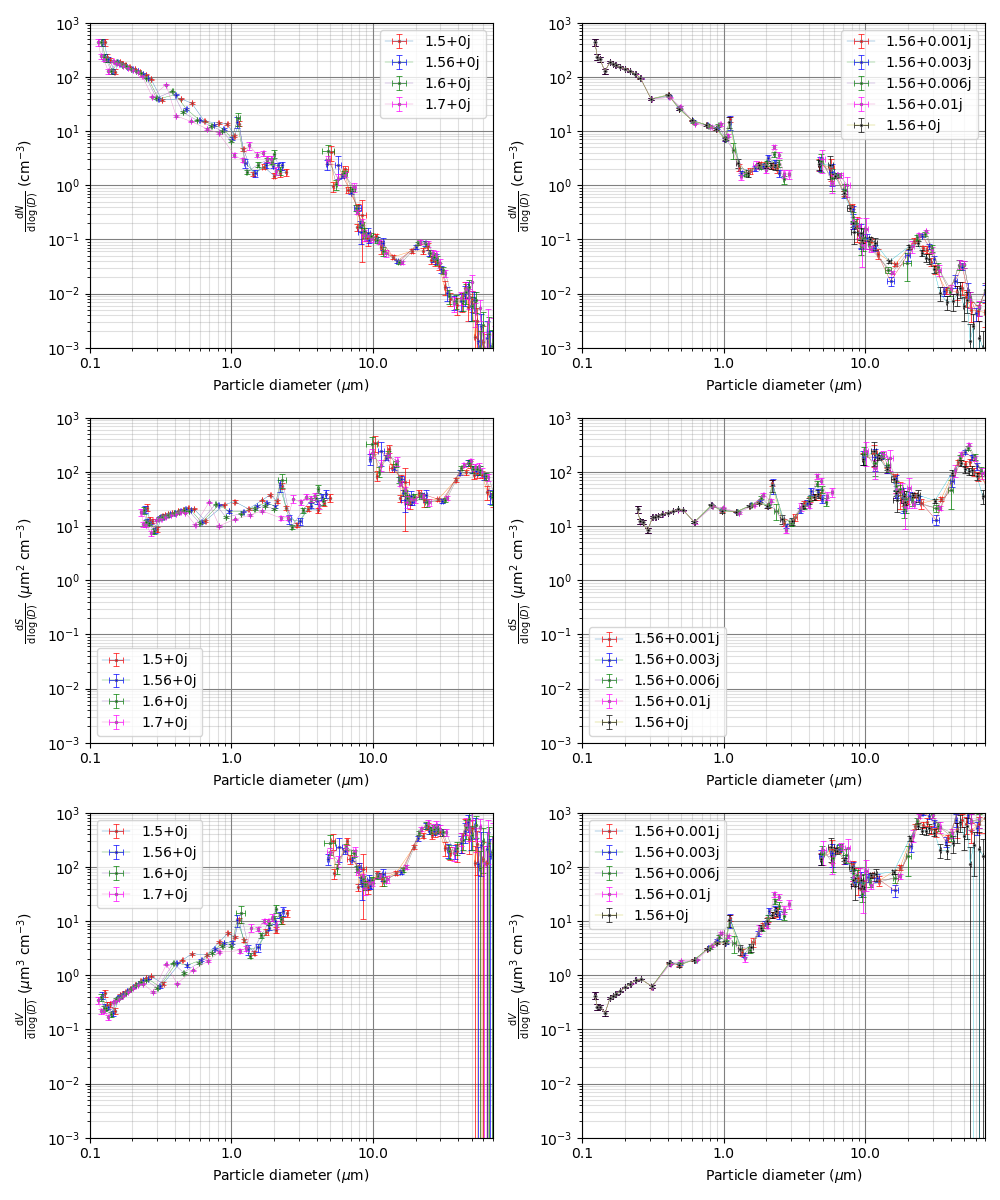

In [19]:
ri_list = asd.get_refractive_indices(pcasp_channel_data_folder, 'PCASP')

# Choice of axes kwargs (see demonstration in Ex. 7)
kwargs = dict(linewidth=0.25,marker='o',elinewidth=0.5,markersize=2,capsize=2,
            markeredgecolor='gray',markeredgewidth=0.5,capthick=0.25,xlim=[0.1,70],ylim=[1e-3,1e3])

fig, ((ax1, ax4), (ax2, ax5), (ax3, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(10,12))
# Iterator for colours
colors = iter(['r', 'b', 'g', 'magenta'])
for ri in ri_list:
    # Loop through all real RIs
    if ri.imag == 0:
        # Move to next colour
        new_color = next(colors)
        kwargs['ecolor']=new_color
        kwargs['markerfacecolor']=new_color
        kwargs['label'] = str(ri)[1:-1]
        pcasp_cal_at_ri = pcasp_calibration.sel(refractive_index = ri)
        pcasp_psds = asd.get_mean_log_psds(pcasp_cal_at_ri, uncorrected_pcasp,
            corrected_pcasp, pcasp_flow, bin_merging=True)
        cdp_cal_at_ri = cdp_calibration.sel(refractive_index = ri)
        cdp_psds = asd.get_mean_log_psds(cdp_cal_at_ri, uncorrected_cdp, corrected_cdp, cdp_flow)
        # Slicing between 2 and 29 (inclusive) removes first and last bins
        asd.plot_dNdlogD(ax1, pcasp_psds.sel(bin=slice(2,29)), False, **kwargs)
        asd.plot_dSdlogD(ax2, pcasp_psds.sel(bin=slice(2,29)), False, **kwargs)
        asd.plot_dVdlogD(ax3, pcasp_psds.sel(bin=slice(2,29)), False, **kwargs)
        kwargs.pop('label',None)
        asd.plot_dNdlogD(ax1, cdp_psds, False, **kwargs)
        asd.plot_dSdlogD(ax2, cdp_psds, False, **kwargs)
        asd.plot_dVdlogD(ax3, cdp_psds, False, **kwargs)

colors = iter(['r', 'b', 'g', 'magenta', 'k'])
for ri in ri_list:
    # Loop through all complex RIs
    if ri.real == 1.56:
        new_color = next(colors)
        kwargs['ecolor']=new_color
        kwargs['markerfacecolor']=new_color
        kwargs['label'] = str(ri)[1:-1]
        pcasp_cal_at_ri = pcasp_calibration.sel(refractive_index = ri)
        pcasp_psds = asd.get_mean_log_psds(pcasp_cal_at_ri, uncorrected_pcasp,
            corrected_pcasp, pcasp_flow, bin_merging=True)
        cdp_cal_at_ri = cdp_calibration.sel(refractive_index = ri)
        cdp_psds = asd.get_mean_log_psds(cdp_cal_at_ri, uncorrected_cdp, corrected_cdp, cdp_flow)
        # Slicing between 2 and 29 (inclusive) removes first and last bins
        asd.plot_dNdlogD(ax4, pcasp_psds.sel(bin=slice(2,29)), False, **kwargs)
        asd.plot_dSdlogD(ax5, pcasp_psds.sel(bin=slice(2,29)), False, **kwargs)
        asd.plot_dVdlogD(ax6, pcasp_psds.sel(bin=slice(2,29)), False, **kwargs)
        kwargs.pop('label',None)
        asd.plot_dNdlogD(ax4, cdp_psds, False, **kwargs)
        asd.plot_dSdlogD(ax5, cdp_psds, False, **kwargs)
        asd.plot_dVdlogD(ax6, cdp_psds, False, **kwargs)
for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    ax.legend()
fig.tight_layout()

### Example - Plot total PCASP number concentration over time - flight c274, run 3

Concentration is calculated by adding up all channels. Error is not calculated since it would be messy to display but would be simple to calculate - you simply divide the concentration in each channel by the flow rate and duration (which is 1s so nothing to do). Sum these errors and square root to add these in quadrature since the Poisson error is a square root anyway.

This plot shows the periods where the filter was shut and can optionally display a data flag for the instrument. Check the metadata for full details of the data flag, but in short - 0 or 1, you're fine to use it, 2 or 3, you're not.

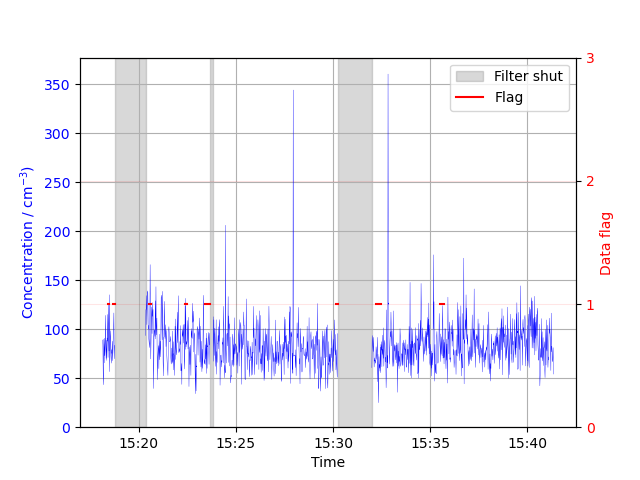

In [20]:
flag = asd.time_slice_data(run_start_times,run_end_times,flight_data['pcasp_flag'])
fig, ax = plt.subplots()
ax = asd.plot_total_number_concentration(ax, corrected_pcasp.sel(bin=slice(2,29)),flag)

### Example - Comparing CDP data with different humidity caps
The CDP - Cloud Droplet Probe - is unsurprisingly designed to measure cloud droplets. We use it to measure aerosol and use the refractive index correction to adjust the channel diameters accordingly. However, large liquid droplets can significantly bias the size distributions, especially in surface area/volume. One way of reducing the likelihood of  droplets being considered is to remove all data points with relative humidity above a certain threshold. Ben Murray suggests an 80% threshold - but by coincidence, in the example here there aren't actually any times where we measured above 80%!

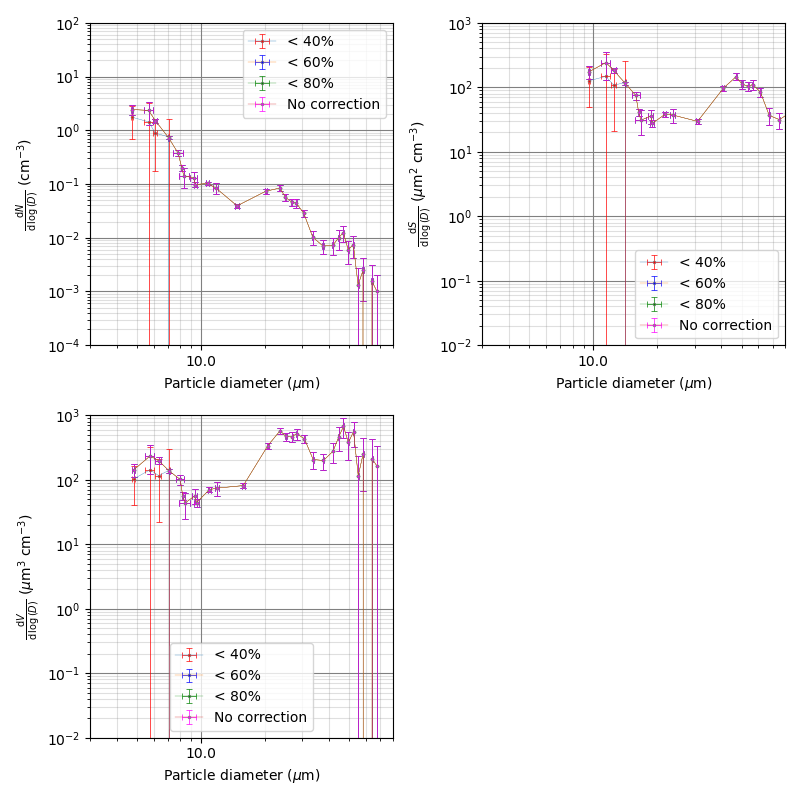

In [21]:
rh_fig, ((rh_ax1, rh_ax2), (rh_ax3, rh_ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
# Get rid of messy fourth axis
rh_ax4.remove()

kwargs = dict(linewidth=0.25,marker='o',elinewidth=0.5,markersize=2,capsize=2,
            markeredgecolor='gray',markeredgewidth=0.5,capthick=0.25,xlim=[3,80])

colors = iter(['r', 'b', 'g', 'magenta', 'k'])
rh_liq = asd.time_slice_data(run_start_times, run_end_times, flight_data['RH_LIQ'])
for rh in [40, 60, 80]:
    # Loop through relative humidity thresholds 40, 60 and 80%
    rh_uncorrected_cdp = asd.mask_humidity_above_threshold(uncorrected_cdp, rh_liq, rh)
    rh_corrected_cdp = asd.mask_humidity_above_threshold(corrected_cdp, rh_liq, rh)
    rh_cdp_psds = asd.get_mean_log_psds(cdp_cal_at_ri, rh_uncorrected_cdp, rh_corrected_cdp,
                                        cdp_flow)
    # Create label for each value
    label = '< ' + str(rh) + '%'
    new_color = next(colors)
    kwargs['ecolor']=new_color
    kwargs['markerfacecolor']=new_color
    kwargs['label'] = label
    
    rh_ax1 = asd.plot_dNdlogD(rh_ax1, rh_cdp_psds, False, **kwargs)
    rh_ax2 = asd.plot_dSdlogD(rh_ax2, rh_cdp_psds, False, **kwargs)
    rh_ax3 = asd.plot_dVdlogD(rh_ax3, rh_cdp_psds, False, **kwargs)

new_color = next(colors)
kwargs['ecolor']=new_color
kwargs['markerfacecolor']=new_color
kwargs['label'] = 'No correction'
cdp_psds = asd.get_mean_log_psds(cdp_cal_at_ri, uncorrected_cdp, corrected_cdp, cdp_flow)

rh_ax1 = asd.plot_dNdlogD(rh_ax1, cdp_psds, True, **kwargs)
rh_ax2 = asd.plot_dSdlogD(rh_ax2, cdp_psds, True, **kwargs)
rh_ax3 = asd.plot_dVdlogD(rh_ax3, cdp_psds, True, **kwargs)
rh_ax1.set_ylim(0.0001,100)
rh_fig.tight_layout()

### Example - Combining PCASP and CDP data to get a total number/size/volume concentration

In [22]:
# This should work with arrays that have a time dimension too.
dN, dS, dV, dN_err, dS_err, dV_err = asd.integrate_distribution_with_errors(pcasp_psds.sel(bin=slice(2,29)), cdp_psds)
dN

72.9244511185522

In [23]:
# Take slice of pcasp data over 500nm
pcasp_over_500 = pcasp_psds.where(pcasp_psds['lin_log_diameter'] > 0.5, drop=True)
pcasp_over_500

<xarray.Dataset>
Dimensions:                   (bin: 12)
Coordinates:
  * bin                       (bin) float64 19.0 20.0 21.0 ... 28.0 29.0 30.0
    refractive_index          complex128 (1.56+0j)
Data variables: (12/22)
    dN                        (bin) float64 1.98 1.009 0.6721 ... 0.04777 0.1086
    dN_err                    (bin) float64 0.04656 0.03322 ... 0.007225 0.0109
    dS                        (bin) float64 2.302 1.821 1.659 ... 0.8034 2.107
    dS_err                    (bin) float64 0.05481 0.06152 ... 0.1234 0.2162
    dV                        (bin) float64 0.2403 0.2327 ... 0.3138 0.8803
    dV_err                    (bin) float64 0.005858 0.00811 ... 0.04908 0.09294
    ...                        ...
    area_as_diameter          (bin) float64 1.217 1.516 1.773 ... 4.628 4.97
    area_as_diam_lower_error  (bin) float64 0.002287 0.005728 ... 0.05421
    area_as_diam_upper_error  (bin) float64 0.002282 0.005706 ... 0.05363
    vol_as_diameter           (bin) float64 0.6143 0.7609 0.8886 ... 2.324 2.492
    vol_as_diam_lower_error   (bin) float64 0.00132 0.002902 ... 0.03121 0.02762
    vol_as_diam_upper_error   (bin) float64 0.001314 0.00288 ... 0.03039 0.02702

# Optional: reading input filter data and metadata
Here, you will need to read your own files. A cell has been left intentionally blank for you to do so.
Examples of the *filters_data* and *filters_metadata* CSVs are included on the Github page if you wish to follow the same layout. *Editor's note - I wouldn't follow the same metadata format, I hate it but I've started so I'll finish...*

In [25]:
# Erin's filter data and metadata
filters_metadata = pd.read_csv(r'..\..\filters\filters_data.csv', index_col='unique_ID')
filters_metadata = filters_metadata[(filters_metadata['material']=='Teflon') & 
                  (filters_metadata['INP_run_ID']!='Blank') & 
                  (filters_metadata['ignore'] == False)]
filters_data = pd.read_csv(r'..\..\filters\subtracted_backgrounds_v3.csv',index_col='temp_bin')

In [ ]:
# This cell is left intentionally blank for you to read in your own filter data and metadata
# filters_data = 
# filters_metadata = 

## Plotting INP concentrations
If you have chosen to load in INP data, you can use the following function to plot it. Also displayed is an example of the use of `kwargs` as previously mentioned.

In [26]:
def inp_plot(ax, filters_data, highlight_filter_ID=None, connect=False, **kwargs):
    """ Plot all INP concentrations of a campaign on a given axis

    Optionally you may highlight a particular INP concentration curve. NOT compatible with
    matplotlib kwargs option due to specific choices to produce the labelling of a single run.

    Parameters
    ----------
    ax: matplotlib axes
        axes to plot on
    filters_data: pandas dataframe
        dataframe containing background-subtracted data
    highlight_filter_id: string, optional
        string containing unique ID of a INP run. All are in the format described above.
    connect: bool, optional
        choose whether or not to 'connect' the lines. Off by default.
    Returns
    -------
    matplotlib axes
        axes with INP plot

    """
    if connect:
        lw = 1.5
        slw = 0.75
    else:
        lw = slw = 0
    temps = filters_data.index
    if highlight_filter_ID != None:
        # Plot specific filter if wanted
        Nt = filters_data[highlight_filter_ID + '_NT']
        Nt_err = filters_data[highlight_filter_ID + '_err']
        Nt_mask = np.isfinite(Nt)

        ax.errorbar(temps[Nt_mask], Nt[Nt_mask], yerr=Nt_err[Nt_mask], marker='o', markersize=4,
                color='red', capsize=2, elinewidth=1.25, linewidth=lw, zorder=3, label=highlight_filter_ID)

    data = filters_data[filters_data.columns[pd.Series(
        filters_data.columns).str.endswith('NT')]]

    first = True
    for column in data:
        mask = np.isfinite(data[column])
        if first:
            # Cheeky workaround to add legend label to just one of the plots
            ax.plot(temps[mask], data[column][mask], marker='o',
                markersize=2, color='lightgray', linewidth=slw, zorder=1, label='All data')
            first = False
        else:
            ax.plot(temps[mask], data[column][mask], marker='o',
                markersize=2, color='lightgray', linewidth=slw, zorder=1)

    ax.set_yscale('log')

    default_kwargs = {
        'xlim': [-35,0],
        'ylim': [12**-2,10**2],
        'xlabel': 'Temperature / \u00b0C',
        'ylabel': 'INP concentration / L\u207b\u00b9'
    }

    ax, kwargs = asd.kwarg_handling(ax, default_kwargs, kwargs)

    ax.grid()
    ax.legend()
    return ax

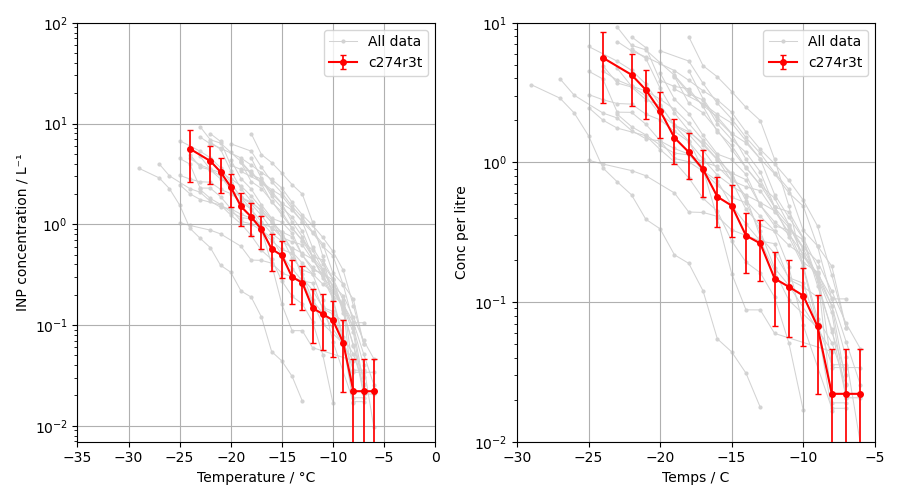

In [27]:
# Plot of INP concentrations - the left uses default plotting options.
inp_only_fig, (standard_inp_ax, custom_inp_ax) = plt.subplots(nrows=1, ncols=2, figsize=(9,5))
kwargs_example = {'xlim':[-30,-5],'ylim':[0.01,10],'xlabel':'Temps / C', 'ylabel':'Conc per litre'}
standard_inp_ax = inp_plot(standard_inp_ax, filters_data, 'c274r3t', True)
custom_inp_ax = inp_plot(custom_inp_ax, filters_data, 'c274r3t', True, **kwargs_example)
inp_only_fig.tight_layout()